# Qutip

Qutip es una librería de Python que permite construir representaciones matriciales (tensoriales) de operadores en MC de forma eficiente y más o menos transparente. También permite resolver ecuaciones de evolución para sistemas abiertos, calcular valores medios y estimadores de correlaciones cuánticas.
Acá van algunos ejemplos.

In [10]:
%matplotlib inline

import numpy as np
import qutip 
import matplotlib.pyplot as plt

In [60]:
### Estado de una base canónica en dimensión 3

In [61]:

qutip.basis(3,2)

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]

### Combinación lineal de estados de una base canónica

In [67]:
psi=(qutip.basis(3,2)+1j * qutip.basis(3,1))
psi

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.+0.j]
 [0.+1.j]
 [1.+0.j]]

In [70]:
### Normalizamos el estado que construimos

In [72]:
psi = psi/ psi.norm()
psi

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.        +0.70710678j]
 [0.70710678+0.j        ]]

In [78]:
###  Constrimos otro estado y calculamos el overlap

chi = qutip.basis(3,0)-qutip.basis(3,2)
chi = chi/chi.norm()

psi.overlap(chi)


(-0.5+0j)

In [80]:
# o
ov=chi.dag()*psi
ov

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[-0.5]]

notar que con overlap obtenemos un número complejo, y con el producto escalar un tensor 1-1. Para recuperar el número complejo, calculamos su traza:

In [82]:
ov.tr()

-0.5

### Matriz que representa la componente z de un espín con s=2:

In [32]:
qutip.jmat(2)[0]

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0.         1.         0.         0.         0.        ]
 [1.         0.         1.22474487 0.         0.        ]
 [0.         1.22474487 0.         1.22474487 0.        ]
 [0.         0.         1.22474487 0.         1.        ]
 [0.         0.         0.         1.         0.        ]]

### Operadores de subida


In [34]:
qutip.create(4)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         1.41421356 0.         0.        ]
 [0.         0.         1.73205081 0.        ]]

### $A^\dagger - A =0$

In [49]:
ad = qutip.create(4)

ad.dag()  -qutip.destroy(4)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

### Conmutador de operadores de subida y bajada, proyectados a dimensión finita:

In [43]:
qutip.commutator(qutip.destroy(4),qutip.create(4))

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -3.]]

### Ejemplo de construccion de un Hamiltoniano, un estado, y encontramos un espectro.

In [51]:
## Parámetros del Hamiltoniano

J=1.
b=.1
## Hamiltoniano de dos cuerpos

H= b*(qutip.tensor(qutip.sigmaz(),qutip.identity(2))+
      qutip.tensor(qutip.identity(2),qutip.sigmaz())
     ) + J*(
    qutip.tensor(qutip.sigmap(),qutip.sigmam())+
   qutip.tensor(qutip.sigmam(),qutip.sigmap()))

print("El espectro de H es ", H.eigenenergies())



El espectro de H es  [-1.  -0.2  0.2  1. ]


### Construimos un estado inicial, y lo hacemos evolucionar con H. Finalmente graficamos la entropía en los subsistemas

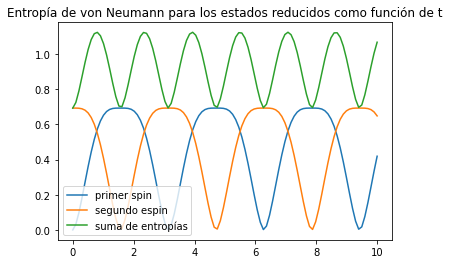

In [54]:
rho0 = qutip.tensor(qutip.projection(2,1,1),.5*qutip.identity(2))

# Evolución de rho0 con H
ts=np.linspace(0,10,100)
res=qutip.mesolve(H, rho0, ts)


plt.title("Entropía de von Neumann para los estados reducidos como función de t")
plt.plot(ts,[qutip.entropy_vn(rho.ptrace([0]))  for rho in res.states], label="primer spin")
plt.plot(ts,[qutip.entropy_vn(rho.ptrace([1]))  for rho in res.states],label="segundo espin")
plt.plot(ts,[qutip.entropy_vn(rho.ptrace([0]))+qutip.entropy_vn(rho.ptrace([1]))  for rho in res.states],label="suma de entropías")
plt.legend()

### Evolución con decoherencia vía dínamica de Lindblad

Aquí hacemos lo mismo que antes, pero introducimos un operador de colapso:

$$
{\bf i}\frac{d\rho}{dt}=[{\bf H},\rho] 
+ {\bf i}\sum_i ({\bf C}_i \rho {\bf C}_i^\dagger-\frac{\{\rho,{\bf C}_i^\dagger {\bf C}_i  \}}{2})
$$
En el ejemplo, ${\bf C}_i={\bf C}_1 = .2(\sigma_z^{(1)}+\sigma_z^{(2)})$

Los detalles están en el help:

[http://qutip.org/docs/3.1.0/guide/dynamics/dynamics-master.html](http://qutip.org/docs/3.1.0/guide/dynamics/dynamics-master.html)

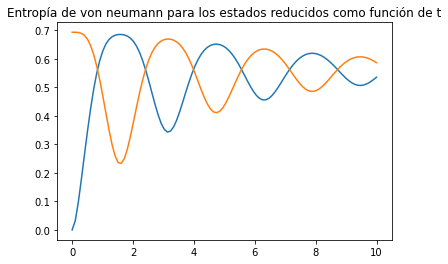

In [57]:
rho0 = qutip.tensor(qutip.projection(2,1,1),.5*qutip.identity(2))

# Evolución de rho0 con H
ts=np.linspace(0,10,100)
collapseops = [.3*qutip.tensor(qutip.identity(2),qutip.sigmaz()),
               .3*qutip.tensor(qutip.sigmaz(),qutip.identity(2))]

res=qutip.mesolve(H, rho0, ts, collapseops)


plt.title("Entropía de von neumann para los estados reducidos como función de t")
plt.plot(ts,[qutip.entropy_vn(rho.ptrace([0]))  for rho in res.states], label="primer spin")
plt.plot(ts,[qutip.entropy_vn(rho.ptrace([1]))  for rho in res.states],label="segundo espin")

### Hamiltoniano de más de dos partículas

Acá va un ejemplo de como podés construir un Hamiltoniano con interacciones de pares
$$
{\bf H}=J\sum_i (\sigma_{x, i}\sigma_{x, i+1 mod N}+\sigma_{y, i}\sigma_{y, i+1 mod N})
$$

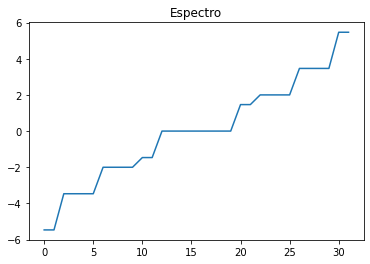

In [86]:
n = 5
idop = qutip.identity(2)
pairintxx = qutip.tensor(qutip.sigmax(),qutip.sigmax())
pairintyy = qutip.tensor(qutip.sigmay(),qutip.sigmay())

Vxx = (sum([
    qutip.tensor([idop for i in range(j) ]+[pairintxx]+ [idop for i in range(n-j-2)])
                 for j in range(n-2)]) + 
qutip.tensor([qutip.sigmax()]+[idop for i in range(n-2)]+[qutip.sigmax()]))


Vyy = (sum([
    qutip.tensor([idop for i in range(j) ]+[pairintyy]+ [idop for i in range(n-j-2)])
                 for j in range(n-2)]) + 
qutip.tensor([qutip.sigmay()]+[idop for i in range(n-2)]+[qutip.sigmay()]))


H = Vxx+Vyy

plt.title("Espectro")
plt.plot(H.eigenenergies())

### Aquí armamos el estado térmico asociado a este H

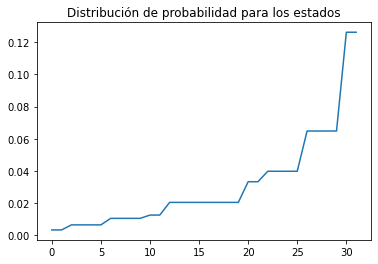

In [97]:
T=3.
rho=(-H/T).expm()
rho = rho/rho.tr()


plt.title("Distribución de probabilidad para los estados")
plt.plot(rho.eigenenergies())